## Warming Up with JAX

- JAX is a library for array-oriented numerical computation (like Numpy) <br>
- It comes with Automatic Differentiation and Just-In-Time Compilation <br>
- This enables high performance machine learning research

- JAX's syntax (for the most part) is just like NumPy's

In [2]:
import jax.numpy as jnp
import numpy as np

- JAX has special transform functions

In [3]:
from jax import grad, jit, vmap, pmap

- JAX's low level API

In [5]:
from jax import lax
# lax is just anagram for XLA

In [18]:
import matplotlib.pyplot as plt
import jax.random

### Very Similar to NumPy

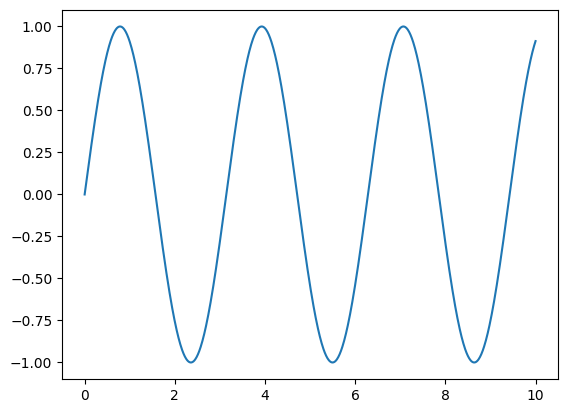

In [9]:
# Create 1000 datapoints from 0 to 10
x_np = np.linspace(0, 10, 1000)
# Create a function
y_np = 2*np.sin(x_np)*np.cos(x_np)
# Plot the function
plt.plot(x_np, y_np)

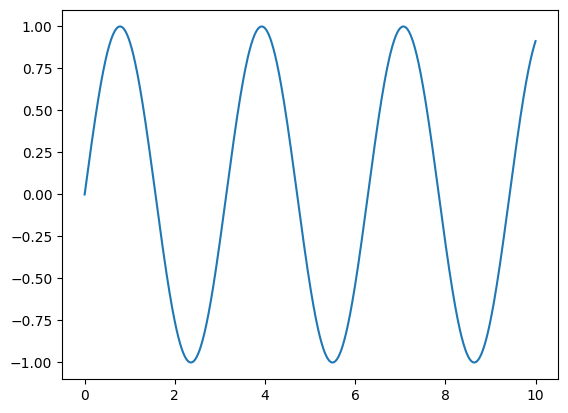

In [11]:
# Create 1000 datapoints from 0 to 10 using JAX
x_jnp = jnp.linspace(0, 10, 1000)
# Create a function using JAX
y_jnp = 2*jnp.sin(x_np)*jnp.cos(x_np)
# Plot the function
plt.plot(x_jnp, y_jnp)

### JAX Arrays are Immutable

In [12]:
size = 10
index = 0
val = 23

In [13]:
print("NumPy Array")
x = np.arange(size)
print(x)
x[index] = val
print(x)

NumPy Array
[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [14]:
print("JAX Array")
x = jnp.arange(size)
print(x)
x[index] = val
print(x)

JAX Array
[0 1 2 3 4 5 6 7 8 9]


TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

### Solution to edit JAX arrays

In [15]:
x = jnp.arange(size)
print(x)
y = x.at[index].set(val)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


### JAX handles random number generation very differently (for a good reason)

In [24]:
seed = 0
key = jax.random.PRNGKey(seed)
# Key is just fancy way of creating a "state"
# Pseudo-random Number Generators(PRNG) are "stateful"
# JAX is not.
# Why? -> Consequence of Functional Programming
# "Stateful" -> It maintains an internal state that is updated each time a new "random" number
#               is produced. The entire sequence of numbers generated depends on this internal
#               state and it's initial value (also known as the "seed")
# This state makes PRNGs deterministic and reproducible
# Rather than relying on a hidden, global state like NumPy, JAX requires the user to explicitly
# manage and pass a "key" -> Aligns with JAX's principle of Func Programming

In [26]:
# Sample 10 random numbers from a normal distribution
x = jax.random.normal(key, (10,))
print(type(x), x)

<class 'jaxlib._jax.ArrayImpl'> [ 1.6226422   2.0252647  -0.43359444 -0.07861735  0.1760909  -0.97208923
 -0.49529874  0.4943786   0.6643493  -0.9501635 ]


### JAX is AI Accelerator Agnostic - Same code runs everywhere

Data automatically pushed to AI Accelerator (GPU/TPU) <br>
No need of .to(device)

In [28]:
size = 3000

# Defining an array
x_jnp = jax.random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size,size)).astype(np.float32)

print("1")
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready() # on GPU - fast (1)

print("2")
%timeit np.dot(x_np, x_np.T) # on CPU - slow (2)

print("3")
%timeit jnp.dot(x_np, x_np.T).block_until_ready() # on GPU but with transfer overhead (3)
# JAX but with NumPy array - will cause the array to be pushed to GPU


print("4")
x_np_device = jax.device_put(x_np) # Push explicitly to device
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready() # same as (1)


# Note: Here "GPU" is synonym for any AI Accelerator used
# Note: block_until_ready() -> async dispatch

1
85.6 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2
68.6 ms ± 990 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3
88.4 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4
86.2 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## JAX Transform Functions

### &nbsp;&nbsp; 1) jit()

- Compiles your function using XLA and caches them 
- Speeeeeed

In [29]:
# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y)
    plt.show()

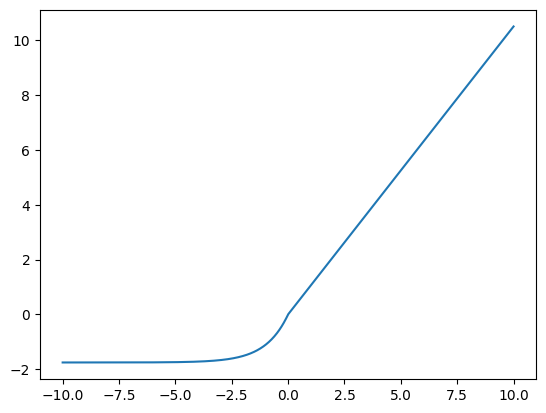

In [30]:
# Define a function
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda*jnp.where(x>0, x, alpha*jnp.exp(x)-alpha)

selu_jit = jit(selu) # Compiles the function

# Visualize selu
visualize_fn(selu)

Benchmark jit vs non-jit

In [32]:
data = jax.random.normal(key, (1000000,))

print("Non-jit Version")
%timeit selu(data).block_until_ready()

print("Jit Version")
%timeit selu_jit(data).block_until_ready()

Non-jit Version
2.19 ms ± 130 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Jit Version
527 μs ± 25.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### &nbsp;&nbsp; 2) grad()

Differentiation can be: 
- manual (a function which does it using hard coded steps)
- symbolic (similar to manual but function uses diff rules like product rules)
- numeric (finite derivaties)
- automatic (used in every DL framwork, also JAX)

In [37]:
# Example of automatic diff

def sum_logistic(x):
    return jnp.sum(1.0/(1.0+jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic # Just renaming

grad_loss = grad(loss)
# By default grad takes the derivative w.r.t. 1st parameter
# Here we have bundled inputs into first parameter so it doesnt matter

print(grad_loss(x))

[0.25       0.19661197 0.10499357]


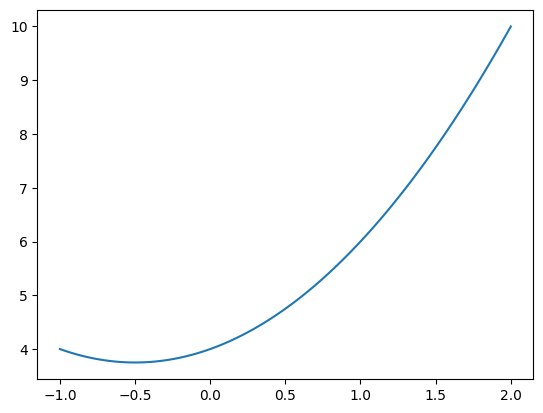

In [40]:
# Another Example

x = 1.
f = lambda x: x**2 + x + 4

visualize_fn(f, l=-1, r=2, n=100)

In [44]:
dfdx = grad(f)
df2dx = grad(dfdx)
print(f"f({x}): {f(x)}")
print(f"df/dx : {dfdx(x)}")
print(f"df2/dx : {df2dx(x)}")

f(1.0): 6.0
df/dx : 3.0
df2/dx : 2.0


### JAX Autodiff Engine is very powerful

In [47]:
from jax import jacfwd, jacrev
# jacfwd and jacrev can find Jacobians
# Jacobians can evaluate derivatives even for vector valued functions

# Simple paraboloid 
f = lambda x, y: x**2 + y**2

# df/dx = 2x
# df/dy = 2y
# J = [ df/dx, df/dy ]
# d2f/dx = 2
# d2f/dy = 2

# Hessian
# H = [ [ d2f/dx, d2f/dxdy ], [ d2f/dydx, d2f/dy ] ]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0,1)), argnums=(0,1)))
    # jacfwd and jacrev together -> Optimization Purposes (Google if you want more info)

print(f"Jacobian: {jacrev(f, argnums=(0, 1))(1.,1.)}")
print(f"Full Hessian: {hessian(f)(1.,1.)}")

Jacobian: (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Full Hessian: ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


### &nbsp;&nbsp; 3) vmap()

- Write your functions as if you are dealing with a single datapoint

In [48]:
# Assume W to be the weights of a linear NN layer
W = jax.random.normal(key, (150,100))

# Treat x as a batch of 10 flattened images
batched_x = jax.random.normal(key, (10,100))

In [51]:
def apply_matrix(x):
    return jnp.dot(W, x)
    # This function only does dot product for single batch
    # W = (150, 100)
    # Cannot directly multiply with (10, 100)

In [53]:
def naive_batch_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

In [54]:
print("Naively Batched")
%timeit naive_batch_apply_matrix(batched_x).block_until_ready()

Naively Batched
346 μs ± 21.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The above way was a naive approach of iterating through the 10 images

In [55]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)
    # (10,100)*(100,150) -> (10,150)

print("Manually Batched")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually Batched
14.2 μs ± 925 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The problem with this is, we have to write completely different functions based on the data <br>
Even though it is fast, this is not desirable <br>
Hence vmap()

In [57]:
@jit
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

print("Auto vectorized by vmap")
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto vectorized by vmap
26.7 μs ± 8.73 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


What if we have more arguments in the function

In [58]:
def apply_matrix(W, x):
    return jnp.dot(W, x)

In [59]:
@jit
def vmap_batched_apply_matrix(W, batched_x):
    return vmap(apply_matrix)(W, batched_x)

In [62]:
%timeit vmap_batched_apply_matrix(W, batched_x).block_until_ready()
# This will throw error

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 150: axis 0 of argument W of type float32[150,100];
  * one axis had size 10: axis 0 of argument x of type float32[10,100]

This is because we are trying to tell to vmap that W has a batch dimension - which it does not! <br>
It's just a weight matrix. <br><br>
Here we will use the in_axes argument

In [63]:
@jit
def vmap_batched_apply_matrix(W, batched_x):
    return vmap(apply_matrix, in_axes=(None,0))(W, batched_x)

In [64]:
%timeit vmap_batched_apply_matrix(W, batched_x).block_until_ready()

25.8 μs ± 2.11 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
